<a href="https://colab.research.google.com/github/avladova/Diagnostics/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%92%D0%A2%D0%942016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import SimpleExpSmoothing

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, roc_curve, roc_auc_score
from scipy import stats

import plotly.express as px
from itertools import combinations
#%pylab inline

In [2]:
url_1 = "https://docs.google.com/spreadsheets/d/1jIFZxrx5oZjlT4ICUKNBIUwugP8OGwmrgXeRz-MRVr4/export?format=csv&gid=3088504"
raw=pd.read_csv(url_1, decimal=',')
raw['Год ВТД'] = raw['Год ВТД'].astype('int64')
raw.drop(columns=['Долгота, L','Широта, B','Высота, H'], inplace=True)
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Идентификация             6273 non-null   object 
 1   Пикет, км                 6273 non-null   float64
 2   Дистанция по одометру, м  6273 non-null   float64
 3   Длина дефекта, мм         6273 non-null   int64  
 4   ширина дефекта, мм        6273 non-null   int64  
 5   Глубина дефекта           6273 non-null   int64  
 6   КБД                       5537 non-null   float64
 7   Ориент., ч                6273 non-null   object 
 8   Номер трубы               6273 non-null   object 
 9   Срок обследования         6273 non-null   object 
 10  Примечание                521 non-null    object 
 11  Результаты шурфовки       90 non-null     object 
 12  Ремонт                    51 non-null     object 
 13  Трубопровод               6273 non-null   object 
 14  Год ВТД 

In [3]:
url_2 = "https://docs.google.com/spreadsheets/d/1yO7zuHTpYmdawrU47h6wPPQ4LANlHBdAXViQv9krwWY/export?format=csv&gid=1158206770"
raw2=pd.read_csv(url_2, decimal=',')
raw2.drop(columns=['Долгота, L','Широта, B','Высота, H'], inplace=True)
raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824 entries, 0 to 2823
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Идентификация             2824 non-null   object 
 1   Пикет, км                 2824 non-null   float64
 2   Дистанция по одометру, м  2824 non-null   float64
 3   Длина дефекта, мм         2824 non-null   int64  
 4   ширина дефекта, мм        2824 non-null   int64  
 5   Глубина дефекта           2824 non-null   int64  
 6   КБД                       1806 non-null   float64
 7   Ориент., ч                2824 non-null   object 
 8   Номер трубы               2824 non-null   object 
 9   Срок обследования         2824 non-null   object 
 10  Примечание                971 non-null    object 
 11  Результаты шурфовки       38 non-null     object 
 12  Ремонт                    32 non-null     object 
 13  Трубопровод               2824 non-null   object 
 14  Год ВТД 

## Быстрый взгляд на данные

In [4]:
df=raw.copy()
df.describe()

,"Пикет, км","Дистанция по одометру, м","Длина дефекта, мм","ширина дефекта, мм",Глубина дефекта,КБД,Год ВТД
count,6273.000000,6273.000000,6273.000000,6273.000000,6273.000000,5537.000000,6273.0
mean,491.504012,75389.212334,345.237526,159.293639,11.454009,0.848327,2016.0
std,45.774622,46318.476594,408.802865,218.763247,5.190242,0.045896,0.0
min,417.018000,18.330000,0.000000,0.000000,0.000000,0.636900,2016.0
25%,445.437000,28775.040000,87.000000,37.000000,10.000000,0.820100,2016.0
50%,489.920000,73786.430000,228.000000,75.000000,12.000000,0.845900,2016.0
75%,530.877000,115230.370000,450.000000,189.000000,13.000000,0.874600,2016.0
max,566.603000,151380.890000,4758.000000,2498.000000,50.000000,1.243200,2016.0


<ipython-input-5-2a7432fe2345>:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  whiskers_data = quantitative_data.groupby(feature_mapping, axis=1).sum()


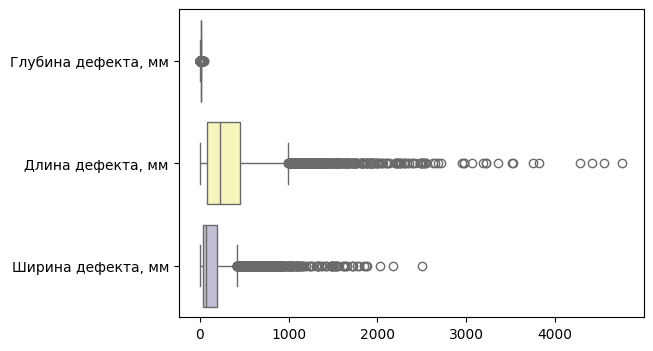

In [5]:
quantitative_data = df.select_dtypes(include=['int64', 'float64'])
# Создаем словарь для объединения признаков
feature_mapping = {
    'ширина дефекта, мм': 'Ширина дефекта, мм',
    'Глубина дефекта': 'Глубина дефекта, мм',
    'Длина дефекта, мм': 'Длина дефекта, мм'
}

# Применяем словарь для объединения признаков в датасете
whiskers_data = quantitative_data.groupby(feature_mapping, axis=1).sum()

# Построение ящиков с усами для объединенных признаков
plt.figure(figsize=(6, 4))
sns.boxplot(data=whiskers_data, orient='h', palette='Set3')  # Горизонтальные ящики с усами с использованием палитры цветов Set3
plt.show()

## Корреляции

In [6]:
whiskers_data.corr()

,"Глубина дефекта, мм","Длина дефекта, мм","Ширина дефекта, мм"
"Глубина дефекта, мм",1.000000,0.174576,-0.004035
"Длина дефекта, мм",0.174576,1.000000,-0.042866
"Ширина дефекта, мм",-0.004035,-0.042866,1.000000


In [7]:
# Выбираем только необходимые признаки и типы для анализа корреляции
subset = df[['Длина дефекта, мм', 'ширина дефекта, мм', 'Глубина дефекта', 'Идентификация']]

# Группировка по идентификации и вычисление коэффициентов корреляции
correlation = subset.groupby('Идентификация').corr()

# Вывод корреляции между выбранными признаками
print(correlation)

                                                 Длина дефекта, мм  \
Идентификация                                                        
Аномалия кольцевого шва      Длина дефекта, мм                 NaN   
                             ширина дефекта, мм                NaN   
                             Глубина дефекта                   NaN   
Аномалия неизвестной природы Длина дефекта, мм            1.000000   
                             ширина дефекта, мм           0.214914   
...                                                            ...   
Утяжина                      ширина дефекта, мм                NaN   
                             Глубина дефекта                   NaN   
Эксцентричный патрон         Длина дефекта, мм                 NaN   
                             ширина дефекта, мм                NaN   
                             Глубина дефекта                   NaN   

                                                 ширина дефекта, мм  \
Идентификация     

<Axes: xlabel='Идентификация'>

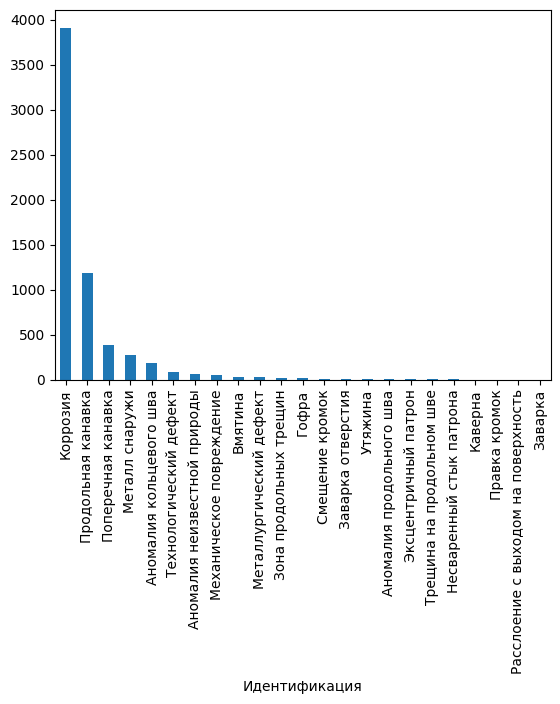

In [8]:
df['Идентификация'].value_counts().plot(kind='bar')

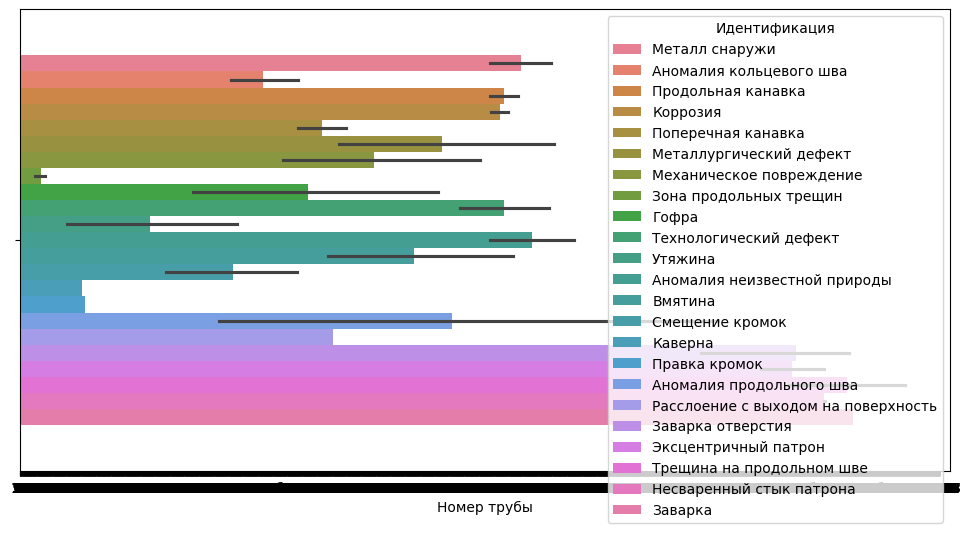

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, hue=df['Идентификация'], x='Номер трубы')
plt.show()

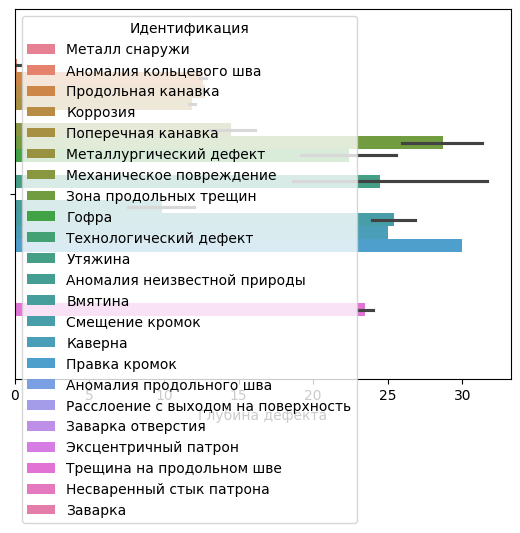

In [10]:
#plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='Глубина дефекта', hue='Идентификация', )
plt.show()

# Увеличение пространства признаков

In [11]:
dfrm=raw.copy()
#dfrm['Индекс'] = dfrm['Пикет, км'] + dfrm['Дистанция по одометру, м']
dfrm.set_index(['Пикет, км','Дистанция по одометру, м','Год ВТД'],inplace=True)
dfrm.head(2)

,,,Идентификация,"Длина дефекта, мм","ширина дефекта, мм",Глубина дефекта,КБД,"Ориент., ч",Номер трубы,Срок обследования,Примечание,Результаты шурфовки,Ремонт,Трубопровод
"Пикет, км","Дистанция по одометру, м",Год ВТД,,,,,,,,,,,,
417.018,18.33,2016,Металл снаружи,0,0,0,NaN,"1,8-1,9",12,более 5 лет,NaN,NaN,NaN,"Газпром трансгаз Ухта, ООО (Пунга-Вуктыл-Ухта ..."
417.021,21.69,2016,Металл снаружи,0,0,0,NaN,"11,8-0,1",14,более 5 лет,Аномалия находится на отводе.,NaN,NaN,"Газпром трансгаз Ухта, ООО (Пунга-Вуктыл-Ухта ..."


## Проверка нормальности признаков

In [12]:
scaler = MinMaxScaler()
# Fit and transform the dataframe using the scaler
whiskers_normalized_values = scaler.fit_transform(whiskers_data)
whiskers_normalized = pd.DataFrame(whiskers_normalized_values, columns=whiskers_data.columns, index=whiskers_data.index)
whiskers_normalized.head(2)

,"Глубина дефекта, мм","Длина дефекта, мм","Ширина дефекта, мм"
0,0.0,0.0,0.0
1,0.0,0.0,0.0


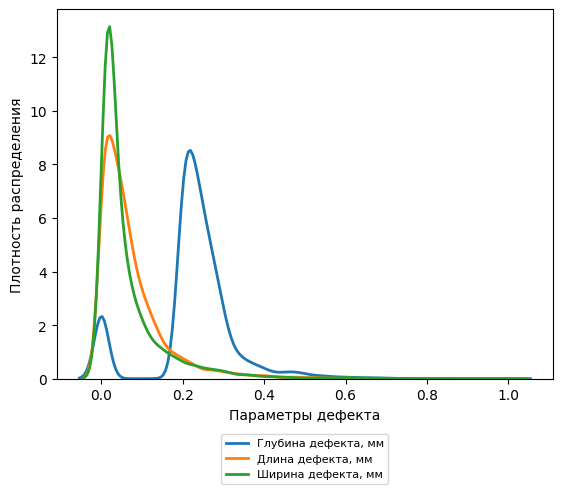

In [13]:
# Построение гистограммы для каждого признака с добавлением меток колонок в легенду
for col in whiskers_normalized.columns.tolist():
    sns.kdeplot(data=whiskers_normalized, x=col, label=col, linewidth=2)
plt.legend(loc='lower center', fontsize=8, bbox_to_anchor=(0.5, -0.3))
plt.xlabel('Параметры дефекта')
plt.ylabel('Плотность распределения')
plt.show()


In [14]:
print("Матожидание признаков:")
print(whiskers_normalized.mean())
print("Стандартное отклонение:")
print(whiskers_normalized.std())
from scipy.stats import skew, kurtosis

# Рассчитываем асимметрию для всех признаков
skewness = whiskers_normalized.apply(skew)
print("Асимметрия признаков:")
print(skewness)

# Рассчитываем эксцесс для всех признаков
kurt = whiskers_normalized.apply(kurtosis)
print("\nЭксцесс признаков:")
print(kurt)

Матожидание признаков:
Глубина дефекта, мм    0.229080
Длина дефекта, мм      0.072559
Ширина дефекта, мм     0.063768
dtype: float64
Стандартное отклонение:
Глубина дефекта, мм    0.103805
Длина дефекта, мм      0.085919
Ширина дефекта, мм     0.087575
dtype: float64
Асимметрия признаков:
Глубина дефекта, мм    0.104016
Длина дефекта, мм      3.126121
Ширина дефекта, мм     3.323146
dtype: float64

Эксцесс признаков:
Глубина дефекта, мм     4.045069
Длина дефекта, мм      16.291989
Ширина дефекта, мм     15.892953
dtype: float64


In [15]:
from scipy.stats import normaltest

# Проводим тест нормальности (включая тест Боумена-Шентона)
statistic, p_value = normaltest(whiskers_normalized)

# Выводим результаты теста
print(f"Статистика теста: {statistic}")
print(f"p-значение: {p_value}")

alpha = 0.05
if (p_value < alpha).any():
    print("Отвергаем нулевую гипотезу: данные не имеют нормальное распределение")
else:
    print("Не отвергаем нулевую гипотезу: данные имеют нормальное распределение")

Статистика теста: [ 596.2061239  4357.68033968 4514.69736096]
p-значение: [3.43150912e-130 0.00000000e+000 0.00000000e+000]
Отвергаем нулевую гипотезу: данные не имеют нормальное распределение
